## DiD Amazon-Wholefoods Merger
#### Created by Sofía Lozano, edited by Jingrui Wu (November 2024, Emory University Department of Economics)
- This notebook cleans data from the combined products and price dataset complied by Jingrui Wu and Sofía Lozano through webscraping Keepa. 
- It transforms variables into dummies, log, and more usable types. It checks for data accuracy and consistency, and runs seven iterations of DiD models. 
- It creates a summary table of the estimates, including Heteroskedastically-Robust Standard Errors. 
-  It attempts to cluster standard errors by product. 
-  Finally, it produces graphs (event study, price trends, average log price trends)
- The notebook can be run by changing the directory to your local one, and opening the file "combined.csv". 

In [1]:
#Import necessary packages: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

In [2]:
#Read data
df3 = pd.read_csv('/Users/sofialozano/Library/CloudStorage/OneDrive-EmoryUniversity/EMORY FALL 2024/ECON 521 POLICY CAUSAL INFERENCE/Final Project 521/Processed Data/combined.csv')
df3.head()

,date,price,asin,market,product_name,product,treatment,post,log_price
0,2013-11-04,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679
1,2013-11-05,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679
2,2013-11-06,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679
3,2013-11-07,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679
4,2013-11-08,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679


In [3]:
# date, product, treatment, post, log_price

# Step 1: Ensure date and categorical variables are in the correct format
df3["date"] = pd.to_datetime(df3["date"])
df3["product"] = df3["product"].astype("category")
df3["post"] = df3["post"].astype(int)  # Ensure `post` is 0/1


In [4]:
# Step 2: Create interaction term
df3["treatment_post"] = df3["treatment"] * df3["post"]

df3["yearmonth"] = df3["date"].dt.to_period("M").astype("category")

In [7]:
# Group by product and calculate summary statistics
grouped_stats = df3.groupby('product').agg(
    min_price=('price', 'min'),
    max_price=('price', 'max'),
    mean_price=('price', 'mean'),
    std_price=('price', 'std'),
    count=('price', 'count'),
    first_date=('date', 'min'),
    last_date=('date', 'max')
).reset_index()

# Display the summary statistics table
grouped_stats

,product,min_price,max_price,mean_price,std_price,count,first_date,last_date
0,BarillaPasta,5.990000,89.990000,12.640811,5.005159,3446,2015-06-01,2024-11-26
1,CassioVintageWatch,3.990000,58.698000,12.191267,9.407965,4015,2013-11-26,2024-11-22
2,RolandArborioSuperfino,13.100000,59.990000,28.156037,6.493151,4991,2011-03-26,2024-11-22
3,almondmilk,1.160000,90.000000,14.257021,6.231498,3669,2014-11-18,2024-12-03
4,arborio,3.080000,39.490000,11.175894,6.825780,3473,2015-05-14,2024-11-14
5,avocados,10.010000,37.750000,20.973013,3.856178,3454,2015-06-21,2024-12-03
6,beanie,1.750000,30.495714,11.581095,4.523410,4769,2011-11-15,2024-12-04
7,blush,1.740000,96.000000,8.752643,14.145131,3797,2014-04-30,2024-12-03
8,dryeraseboard,50.710000,85.900000,62.432660,5.440208,3286,2015-12-07,2024-12-04
9,eyebrow,9.990000,54.990000,23.803337,4.598399,3725,2014-09-23,2024-12-03


In [8]:
# Calculate the summary statistics for the entire dataset (ungrouped)
ungrouped_stats = {
    'product': 'All Products',
    'min_price': df3['price'].min(),
    'max_price': df3['price'].max(),
    'mean_price': df3['price'].mean(),
    'std_price': df3['price'].std(),
    'count': ('price', 'count'),  # Add count of observations
    'first_date': df3['date'].min(),
    'last_date': df3['date'].max(),
    'ungrouped': True
}

# Convert the dictionary to a DataFrame
ungrouped_stats_df = pd.DataFrame([ungrouped_stats])

# Append the ungrouped row to summary_stats
summary_stats = pd.concat([grouped_stats, ungrouped_stats_df], ignore_index=True)

# Display the updated summary_stats
summary_stats

,product,min_price,max_price,mean_price,std_price,count,first_date,last_date,ungrouped
0,BarillaPasta,5.990000,89.990000,12.640811,5.005159,3446,2015-06-01,2024-11-26,NaN
1,CassioVintageWatch,3.990000,58.698000,12.191267,9.407965,4015,2013-11-26,2024-11-22,NaN
2,RolandArborioSuperfino,13.100000,59.990000,28.156037,6.493151,4991,2011-03-26,2024-11-22,NaN
3,almondmilk,1.160000,90.000000,14.257021,6.231498,3669,2014-11-18,2024-12-03,NaN
4,arborio,3.080000,39.490000,11.175894,6.825780,3473,2015-05-14,2024-11-14,NaN
5,avocados,10.010000,37.750000,20.973013,3.856178,3454,2015-06-21,2024-12-03,NaN
6,beanie,1.750000,30.495714,11.581095,4.523410,4769,2011-11-15,2024-12-04,NaN
7,blush,1.740000,96.000000,8.752643,14.145131,3797,2014-04-30,2024-12-03,NaN
8,dryeraseboard,50.710000,85.900000,62.432660,5.440208,3286,2015-12-07,2024-12-04,NaN
9,eyebrow,9.990000,54.990000,23.803337,4.598399,3725,2014-09-23,2024-12-03,NaN


In [9]:
# Round the values to 2 decimal places
summary_stats[['min_price', 'max_price', 'mean_price', 'std_price']] = summary_stats[['min_price', 'max_price', 'mean_price', 'std_price']].round(2)

# Update the count value for "All Products"
summary_stats.loc[summary_stats['product'] == 'All Products', 'count'] = len(df3)

# Display the updated summary_stats
summary_stats

,product,min_price,max_price,mean_price,std_price,count,first_date,last_date,ungrouped
0,BarillaPasta,5.99,89.99,12.64,5.01,3446,2015-06-01,2024-11-26,NaN
1,CassioVintageWatch,3.99,58.70,12.19,9.41,4015,2013-11-26,2024-11-22,NaN
2,RolandArborioSuperfino,13.10,59.99,28.16,6.49,4991,2011-03-26,2024-11-22,NaN
3,almondmilk,1.16,90.00,14.26,6.23,3669,2014-11-18,2024-12-03,NaN
4,arborio,3.08,39.49,11.18,6.83,3473,2015-05-14,2024-11-14,NaN
5,avocados,10.01,37.75,20.97,3.86,3454,2015-06-21,2024-12-03,NaN
6,beanie,1.75,30.50,11.58,4.52,4769,2011-11-15,2024-12-04,NaN
7,blush,1.74,96.00,8.75,14.15,3797,2014-04-30,2024-12-03,NaN
8,dryeraseboard,50.71,85.90,62.43,5.44,3286,2015-12-07,2024-12-04,NaN
9,eyebrow,9.99,54.99,23.80,4.60,3725,2014-09-23,2024-12-03,NaN


## Now we create separate models using each of the treatment products, with all the controls: 

In [13]:
#Controls plus avocado: 
df_avocado_t = df3[(df3['treatment'] == 0) | (df3['product_name'] == 'avocados')]
df_avocado_t.head()


,date,price,asin,market,product_name,product,treatment,post,log_price,treatment_post,yearmonth
0,2013-11-04,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679,0,2013-11
1,2013-11-05,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679,0,2013-11
2,2013-11-06,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679,0,2013-11
3,2013-11-07,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679,0,2013-11
4,2013-11-08,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679,0,2013-11


In [14]:
formula_avocados = "log_price ~ treatment_post + C(product) + C(yearmonth)"

In [15]:
model_avocados = smf.ols(formula_avocados, data=df_avocado_t).fit()
summary = model_avocados.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     2567.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:20:44   Log-Likelihood:                -29135.
No. Observations:               70551   AIC:                         5.864e+04
Df Residuals:                   70367   BIC:                         6.033e+04
Df Model:                         183                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                              -1.892e+09   7.98e+09     -0.237      0.813   -1.75e+10    1.37e+10
C(product)[T.CassioVintageWatch]        1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.RolandArborioSuperfino]   -4.077e+06   1.72e+07     -0.237      0.813   -3.78e+07    2.96e+07
C(product)[T.almondmilk]               -7.715e+06   3.25e+07     -0.237      0.813   -7.15e+07    5.61e+07
C(product)[T.arborio]                   4.606e+06   1.94e+07      0.237      0.813   -3.35e+07    4.27e+07
C(product)[T.avocados]                  1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.beanie]                    1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.blush]                     1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.dryeraseboard]             1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.eyebrow]                   1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.foundation]                1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.headbands]                 1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.hotwheels]                 1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.knife]                     1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.markers]                   1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.measuringcups]             1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.nutmix]                    6.827e+06   2.88e+07      0.237      0.813   -4.96e+07    6.33e+07
C(product)[T.stanley]                   1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.tents]                     1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.toasteroven]               1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.toothbrush]                1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.tshirt]                    1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(product)[T.umbrella]                  1.892e+09   7.98e+09      0.237      0.813   -1.37e+10    1.75e+10
C(yearmonth)[T.Period('2011-04', 'M')]    -0.0065      0.103     -0.063      0.949      -0.208       0.195
C(yearmonth)[T.Period('2011-05', 'M')]    -0.2005      0.103     -1.952      0.051      -0.402       0.001
C(yearmonth)[T.Period('2011-06', 'M')]    -0.2587      0.103     -2.511      0.012     

In [16]:
#Controls plus almondmilk: 
df_almondmilk_t = df3[(df3['treatment'] == 0) | (df3['product_name'] == 'almondmilk')]
df_almondmilk_t.head()

#Check if almondmilk is in the product_name column:
'almondmilk' in df_almondmilk_t['product_name'].unique()

#Create formula
formula_almondmilk = "log_price ~ treatment_post + C(product) + C(yearmonth)"

#Fit model: 
model_almondmilk = smf.ols(formula_almondmilk, data=df_almondmilk_t).fit()
summary = model_almondmilk.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     2496.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:20:48   Log-Likelihood:                -30277.
No. Observations:               70766   AIC:                         6.092e+04
Df Residuals:                   70582   BIC:                         6.261e+04
Df Model:                         183                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                              -7.828e+08   1.21e+10     -0.065      0.948   -2.44e+10    2.29e+10
C(product)[T.CassioVintageWatch]        7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.RolandArborioSuperfino]   -1.011e+06   1.56e+07     -0.065      0.948   -3.16e+07    2.95e+07
C(product)[T.almondmilk]                7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.arborio]                  -7.938e+05   1.22e+07     -0.065      0.948   -2.48e+07    2.32e+07
C(product)[T.avocados]                 -3.054e+05   4.71e+06     -0.065      0.948   -9.54e+06    8.93e+06
C(product)[T.beanie]                    7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.blush]                     7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.dryeraseboard]             7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.eyebrow]                   7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.foundation]                7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.headbands]                 7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.hotwheels]                 7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.knife]                     7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.markers]                   7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.measuringcups]             7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.nutmix]                    7.109e+06    1.1e+08      0.065      0.948   -2.08e+08    2.22e+08
C(product)[T.stanley]                   7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.tents]                     7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.toasteroven]               7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.toothbrush]                7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.tshirt]                    7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(product)[T.umbrella]                  7.828e+08   1.21e+10      0.065      0.948   -2.29e+10    2.44e+10
C(yearmonth)[T.Period('2011-04', 'M')]    -0.0065      0.105     -0.062      0.950      -0.211       0.198
C(yearmonth)[T.Period('2011-05', 'M')]    -0.2005      0.104     -1.923      0.054      -0.405       0.004
C(yearmonth)[T.Period('2011-06', 'M')]    -0.2587      0.105     -2.474      0.013     

In [17]:
#Controls plus nutmix: 
df_nutmix_t = df3[(df3['treatment'] == 0) | (df3['product_name'] == 'nutmix')]
df_nutmix_t.head()

#Check if almondmilk is in the product_name column:
'nutmix' in df_nutmix_t['product_name'].unique()

#Create formula
formula_nutmix = "log_price ~ treatment_post + C(product) + C(yearmonth)"

#Fit model: 
model_nutmix = smf.ols(formula_nutmix, data=df_nutmix_t).fit()
summary = model_nutmix.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     2458.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:20:52   Log-Likelihood:                -31141.
No. Observations:               71505   AIC:                         6.265e+04
Df Residuals:                   71321   BIC:                         6.434e+04
Df Model:                         183                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               1.105e+10    1.2e+10      0.920      0.358   -1.25e+10    3.46e+10
C(product)[T.CassioVintageWatch]       -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.RolandArborioSuperfino]   -9.486e+06   1.03e+07     -0.920      0.358   -2.97e+07    1.07e+07
C(product)[T.almondmilk]                 1.47e+07    1.6e+07      0.920      0.358   -1.66e+07     4.6e+07
C(product)[T.arborio]                   3.423e+07   3.72e+07      0.920      0.358   -3.87e+07    1.07e+08
C(product)[T.avocados]                  -6.64e+07   7.22e+07     -0.920      0.358   -2.08e+08    7.51e+07
C(product)[T.beanie]                   -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.blush]                    -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.dryeraseboard]            -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.eyebrow]                  -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.foundation]               -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.headbands]                -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.hotwheels]                -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.knife]                    -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.markers]                  -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.measuringcups]            -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.nutmix]                   -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.stanley]                  -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.tents]                    -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.toasteroven]              -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.toothbrush]               -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.tshirt]                   -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(product)[T.umbrella]                 -1.105e+10    1.2e+10     -0.920      0.358   -3.46e+10    1.25e+10
C(yearmonth)[T.Period('2011-04', 'M')]    -0.0065      0.105     -0.062      0.951      -0.213       0.200
C(yearmonth)[T.Period('2011-05', 'M')]    -0.2004      0.105     -1.909      0.056      -0.406       0.005
C(yearmonth)[T.Period('2011-06', 'M')]    -0.2586      0.105     -2.455      0.014     

In [18]:
# Controls plus BarillaPasta:
df_barillapasta_t = df3[(df3['treatment'] == 0) | (df3['product_name'] == 'BarillaPasta')]
df_barillapasta_t.head()

# Check if BarillaPasta is in the product_name column:
'BarillaPasta' in df_barillapasta_t['product_name'].unique()

# Create formula
formula_barillapasta = "log_price ~ treatment_post + C(product) + C(yearmonth)"

# Fit model:
model_barillapasta = smf.ols(formula_barillapasta, data=df_barillapasta_t).fit()
summary = model_barillapasta.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     2558.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:20:57   Log-Likelihood:                -29365.
No. Observations:               70543   AIC:                         5.910e+04
Df Residuals:                   70359   BIC:                         6.078e+04
Df Model:                         183                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  2.4747      0.093     26.641      0.000       2.293       2.657
C(product)[T.CassioVintageWatch]          -0.2345      0.015    -16.135      0.000      -0.263      -0.206
C(product)[T.RolandArborioSuperfino]   -2.175e-14    2.8e-14     -0.778      0.437   -7.66e-14    3.31e-14
C(product)[T.almondmilk]               -1.301e-14   1.92e-14     -0.679      0.497   -5.06e-14    2.45e-14
C(product)[T.arborio]                   1.882e-14   2.66e-14      0.707      0.480   -3.34e-14     7.1e-14
C(product)[T.avocados]                  2.684e-14   3.82e-14      0.703      0.482    -4.8e-14    1.02e-13
C(product)[T.beanie]                      -0.1960      0.014    -13.625      0.000      -0.224      -0.168
C(product)[T.blush]                       -0.7491      0.015    -51.348      0.000      -0.778      -0.720
C(product)[T.dryeraseboard]                1.5047      0.015    101.637      0.000       1.476       1.534
C(product)[T.eyebrow]                      0.5401      0.015     36.972      0.000       0.511       0.569
C(product)[T.foundation]                  -0.3354      0.015    -22.575      0.000      -0.364      -0.306
C(product)[T.headbands]                   -1.2751      0.014    -88.788      0.000      -1.303      -1.247
C(product)[T.hotwheels]                   -0.8627      0.014    -60.074      0.000      -0.891      -0.835
C(product)[T.knife]                        0.8882      0.015     59.694      0.000       0.859       0.917
C(product)[T.markers]                      0.3093      0.014     21.426      0.000       0.281       0.338
C(product)[T.measuringcups]                0.2310      0.015     15.823      0.000       0.202       0.260
C(product)[T.nutmix]                   -2.245e-14    2.9e-14     -0.775      0.438   -7.92e-14    3.43e-14
C(product)[T.stanley]                      0.5288      0.015     36.164      0.000       0.500       0.557
C(product)[T.tents]                        0.4427      0.014     30.797      0.000       0.415       0.471
C(product)[T.toasteroven]                  2.6016      0.015    179.136      0.000       2.573       2.630
C(product)[T.toothbrush]                   1.0928      0.015     74.243      0.000       1.064       1.122
C(product)[T.tshirt]                      -0.7341      0.015    -50.130      0.000      -0.763      -0.705
C(product)[T.umbrella]                     0.5168      0.015     34.870      0.000       0.488       0.546
C(yearmonth)[T.Period('2011-04', 'M')]    -0.0065      0.103     -0.063      0.950      -0.209       0.196
C(yearmonth)[T.Period('2011-05', 'M')]    -0.2005      0.103     -1.946      0.052      -0.402       0.001
C(yearmonth)[T.Period('2011-06', 'M')]    -0.2587      0.103     -2.502      0.012     

In [19]:
# Controls plus arborio:
df_arborio_t = df3[(df3['treatment'] == 0) | (df3['product_name'] == 'arborio')]
df_arborio_t.head()

# Check if arborio is in the product_name column:
'arborio' in df_arborio_t['product_name'].unique()

# Create formula
formula_arborio = "log_price ~ treatment_post + C(product) + C(yearmonth)"

# Fit model:
model_arborio = smf.ols(formula_arborio, data=df_arborio_t).fit()
summary = model_arborio.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     2532.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:21:01   Log-Likelihood:                -30232.
No. Observations:               70570   AIC:                         6.083e+04
Df Residuals:                   70386   BIC:                         6.252e+04
Df Model:                         183                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               1.588e+09   8.86e+09      0.179      0.858   -1.58e+10    1.89e+10
C(product)[T.CassioVintageWatch]       -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.RolandArborioSuperfino]   -6.343e+04   3.54e+05     -0.179      0.858   -7.57e+05     6.3e+05
C(product)[T.almondmilk]                1.439e+06   8.03e+06      0.179      0.858   -1.43e+07    1.72e+07
C(product)[T.arborio]                  -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.avocados]                  2.381e+06   1.33e+07      0.179      0.858   -2.37e+07    2.84e+07
C(product)[T.beanie]                   -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.blush]                    -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.dryeraseboard]            -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.eyebrow]                  -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.foundation]               -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.headbands]                -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.hotwheels]                -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.knife]                    -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.markers]                  -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.measuringcups]            -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.nutmix]                   -9.599e+05   5.36e+06     -0.179      0.858   -1.15e+07    9.54e+06
C(product)[T.stanley]                  -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.tents]                    -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.toasteroven]              -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.toothbrush]               -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.tshirt]                   -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(product)[T.umbrella]                 -1.588e+09   8.86e+09     -0.179      0.858   -1.89e+10    1.58e+10
C(yearmonth)[T.Period('2011-04', 'M')]    -0.0065      0.105     -0.062      0.950      -0.212       0.199
C(yearmonth)[T.Period('2011-05', 'M')]    -0.2005      0.104     -1.922      0.055      -0.405       0.004
C(yearmonth)[T.Period('2011-06', 'M')]    -0.2587      0.105     -2.472      0.013     

In [20]:
# Controls plus RolandArborioSuperfino:
df_rolandarborio_t = df3[(df3['treatment'] == 0) | (df3['product_name'] == 'RolandArborioSuperfino')]
df_rolandarborio_t.head()

# Check if RolandArborioSuperfino is in the product_name column:
'RolandArborioSuperfino' in df_rolandarborio_t['product_name'].unique()

# Create formula
formula_rolandarborio = "log_price ~ treatment_post + C(product) + C(yearmonth)"

# Fit model:
model_rolandarborio = smf.ols(formula_rolandarborio, data=df_rolandarborio_t).fit()
summary = model_rolandarborio.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     2683.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:21:06   Log-Likelihood:                -28862.
No. Observations:               72088   AIC:                         5.809e+04
Df Residuals:                   71904   BIC:                         5.978e+04
Df Model:                         183                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                              -1.134e+09   7.66e+09     -0.148      0.882   -1.61e+10    1.39e+10
C(product)[T.CassioVintageWatch]        1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.RolandArborioSuperfino]    1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.almondmilk]               -3.113e+06    2.1e+07     -0.148      0.882   -4.43e+07    3.81e+07
C(product)[T.arborio]                  -1.033e+06   6.98e+06     -0.148      0.882   -1.47e+07    1.26e+07
C(product)[T.avocados]                  6.657e+05   4.49e+06      0.148      0.882   -8.14e+06    9.47e+06
C(product)[T.beanie]                    1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.blush]                     1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.dryeraseboard]             1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.eyebrow]                   1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.foundation]                1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.headbands]                 1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.hotwheels]                 1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.knife]                     1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.markers]                   1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.measuringcups]             1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.nutmix]                   -4.374e+06   2.95e+07     -0.148      0.882   -6.23e+07    5.35e+07
C(product)[T.stanley]                   1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.tents]                     1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.toasteroven]               1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.toothbrush]                1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.tshirt]                    1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(product)[T.umbrella]                  1.134e+09   7.66e+09      0.148      0.882   -1.39e+10    1.61e+10
C(yearmonth)[T.Period('2011-04', 'M')]    -0.0099      0.086     -0.115      0.909      -0.178       0.159
C(yearmonth)[T.Period('2011-05', 'M')]    -0.1313      0.086     -1.532      0.126      -0.299       0.037
C(yearmonth)[T.Period('2011-06', 'M')]    -0.1701      0.086     -1.978      0.048     

## We create a formula for the general model (which is the 7th iteration)

In [21]:
# Create formula for the general model
formula_general = "log_price ~ treatment_post + C(product) + C(yearmonth)"

# Fit the model using the entire df3 dataframe
model_general = smf.ols(formula_general, data=df3).fit()

# Display the summary of the general model
summary_general = model_general.summary()
summary_general

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     2657.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:21:12   Log-Likelihood:                -36786.
No. Observations:               90538   AIC:                         7.395e+04
Df Residuals:                   90349   BIC:                         7.573e+04
Df Model:                         188                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  2.4981      0.078     32.060      0.000       2.345       2.651
C(product)[T.CassioVintageWatch]          -0.3665      0.010    -38.194      0.000      -0.385      -0.348
C(product)[T.RolandArborioSuperfino]       0.8164      0.008     99.153      0.000       0.800       0.833
C(product)[T.almondmilk]                   0.0828      0.009      9.591      0.000       0.066       0.100
C(product)[T.arborio]                     -0.2131      0.009    -24.365      0.000      -0.230      -0.196
C(product)[T.avocados]                     0.5343      0.009     61.023      0.000       0.517       0.551
C(product)[T.beanie]                      -0.3229      0.009    -34.744      0.000      -0.341      -0.305
C(product)[T.blush]                       -0.8815      0.010    -90.801      0.000      -0.901      -0.863
C(product)[T.dryeraseboard]                1.3721      0.010    136.524      0.000       1.352       1.392
C(product)[T.eyebrow]                      0.4065      0.010     41.703      0.000       0.387       0.426
C(product)[T.foundation]                  -0.4676      0.010    -46.226      0.000      -0.487      -0.448
C(product)[T.headbands]                   -1.3998      0.009   -151.755      0.000      -1.418      -1.382
C(product)[T.hotwheels]                   -0.9874      0.009   -107.051      0.000      -1.006      -0.969
C(product)[T.knife]                        0.7562      0.010     74.504      0.000       0.736       0.776
C(product)[T.markers]                      0.1807      0.009     19.229      0.000       0.162       0.199
C(product)[T.measuringcups]                0.0979      0.010     10.059      0.000       0.079       0.117
C(product)[T.nutmix]                       0.0287      0.008      3.429      0.001       0.012       0.045
C(product)[T.stanley]                      0.3949      0.010     40.419      0.000       0.376       0.414
C(product)[T.tents]                        0.3166      0.009     34.173      0.000       0.298       0.335
C(product)[T.toasteroven]                  2.4698      0.010    257.776      0.000       2.451       2.489
C(product)[T.toothbrush]                   0.9606      0.010     96.652      0.000       0.941       0.980
C(product)[T.tshirt]                      -0.8680      0.010    -88.479      0.000      -0.887      -0.849
C(product)[T.umbrella]                     0.3841      0.010     38.148      0.000       0.364       0.404
C(yearmonth)[T.Period('2011-04', 'M')]    -0.0190      0.086     -0.220      0.826      -0.189       0.150
C(yearmonth)[T.Period('2011-05', 'M')]    -0.1405      0.086     -1.629      0.103      -0.309       0.028
C(yearmonth)[T.Period('2011-06', 'M')]    -0.1793      0.086     -2.073      0.038     

## We fit the models with HC3 errors and produce a summary of the results

In [22]:
# Fit models with HC3 standard errors
model_avocados_hc3 = smf.ols(formula_avocados, data=df_avocado_t).fit(cov_type='HC3')
model_almondmilk_hc3 = smf.ols(formula_almondmilk, data=df_almondmilk_t).fit(cov_type='HC3')
model_nutmix_hc3 = smf.ols(formula_nutmix, data=df_nutmix_t).fit(cov_type='HC3')
model_barillapasta_hc3 = smf.ols(formula_barillapasta, data=df_barillapasta_t).fit(cov_type='HC3')
model_arborio_hc3 = smf.ols(formula_arborio, data=df_arborio_t).fit(cov_type='HC3')
model_rolandarborio_hc3 = smf.ols(formula_rolandarborio, data=df_rolandarborio_t).fit(cov_type='HC3')
model_general_hc3 = smf.ols(formula_general, data=df3).fit(cov_type='HC3')

In [23]:
# Extract treatment effects from each model summary
treatment_effects = {
    "Model": ["Avocados", "Almondmilk", "Nutmix", "BarillaPasta", "Arborio", "RolandArborioSuperfino", "General"],
    "Treatment*Post": [
        model_avocados.params["treatment_post"],
        model_almondmilk.params["treatment_post"],
        model_nutmix.params["treatment_post"],
        model_barillapasta.params["treatment_post"],
        model_arborio.params["treatment_post"],
        model_rolandarborio.params["treatment_post"],
        model_general.params["treatment_post"]
    ],
    "P-Value": [
        model_avocados.pvalues["treatment_post"],
        model_almondmilk.pvalues["treatment_post"],
        model_nutmix.pvalues["treatment_post"],
        model_barillapasta.pvalues["treatment_post"],
        model_arborio.pvalues["treatment_post"],
        model_rolandarborio.pvalues["treatment_post"],
        model_general.pvalues["treatment_post"]
    ],
    "Standard Error": [
        model_avocados.bse["treatment_post"],
        model_almondmilk.bse["treatment_post"],
        model_nutmix.bse["treatment_post"],
        model_barillapasta.bse["treatment_post"],
        model_arborio.bse["treatment_post"],
        model_rolandarborio.bse["treatment_post"],
        model_general.bse["treatment_post"]
    ],
    "HC3 Standard Error": [
        model_avocados_hc3.bse["treatment_post"],
        model_almondmilk_hc3.bse["treatment_post"],
        model_nutmix_hc3.bse["treatment_post"],
        model_barillapasta_hc3.bse["treatment_post"],
        model_arborio_hc3.bse["treatment_post"],
        model_rolandarborio_hc3.bse["treatment_post"],
        model_general_hc3.bse["treatment_post"]
    ]
}

# Create a DataFrame to display the treatment effects
df_treatment_effects = pd.DataFrame(treatment_effects)
# Print the heading
print("Summary of Treatment Effects")
df_treatment_effects

Summary of Treatment Effects


,Model,Treatment*Post,P-Value,Standard Error,HC3 Standard Error
0,Avocados,-0.271893,3.295986e-71,0.015221,4.738143e-08
1,Almondmilk,-0.446268,1.724919e-216,0.014160,2.835916e-06
2,Nutmix,-0.396696,5.893669e-236,0.012049,1.406440e-07
3,BarillaPasta,-0.173270,9.110340e-30,0.015283,1.412264e-02
4,Arborio,-0.950947,0.000000e+00,0.015204,1.132617e-07
5,RolandArborioSuperfino,-0.060312,2.750820e-08,0.010853,1.366752e-04
6,General,-0.345581,0.000000e+00,0.006049,6.309041e-03


## Checks to ensure data consistency before clustering standard errors: 

In [24]:
print(df3['product'].unique())

['toasteroven', 'blush', 'hotwheels', 'dryeraseboard', 'RolandArborioSuperfino', ..., 'almondmilk', 'foundation', 'headbands', 'stanley', 'nutmix']
Length: 23
Categories (23, object): ['BarillaPasta', 'CassioVintageWatch', 'RolandArborioSuperfino', 'almondmilk', ..., 'toasteroven', 'toothbrush', 'tshirt', 'umbrella']


In [25]:
# Convert 'product' column to a categorical type
df3['product'] = df3['product'].astype('category')

# Now you can access the categories
print(df3['product'].cat.categories)

Index(['BarillaPasta', 'CassioVintageWatch', 'RolandArborioSuperfino',
       'almondmilk', 'arborio', 'avocados', 'beanie', 'blush', 'dryeraseboard',
       'eyebrow', 'foundation', 'headbands', 'hotwheels', 'knife', 'markers',
       'measuringcups', 'nutmix', 'stanley', 'tents', 'toasteroven',
       'toothbrush', 'tshirt', 'umbrella'],
      dtype='object')


In [26]:
print(len(df3))  # Total rows in df3
print(len(df3['product']))  # Total rows in 'product'
print(df3['product'].isnull().sum())  # Check for any missing values

90633
90633
0


In [27]:
print(df3['product'].nunique())  # Number of unique categories
print(df3['product'].value_counts())  # Count of each category

23
headbands                 5005
hotwheels                 5005
RolandArborioSuperfino    4991
tents                     4863
beanie                    4769
markers                   4467
nutmix                    4408
toasteroven               4049
CassioVintageWatch        4015
blush                     3871
measuringcups             3755
eyebrow                   3725
stanley                   3683
almondmilk                3669
tshirt                    3614
arborio                   3473
BarillaPasta              3467
avocados                  3454
toothbrush                3420
dryeraseboard             3286
umbrella                  3263
foundation                3209
knife                     3172
Name: product, dtype: int64


In [28]:
df3['product_code'] = df3['product'].cat.codes  # Generate category codes


In [29]:
print(df3['product'].nunique())  # Number of unique product categories
print(df3['product_code'].nunique())  # Number of unique codes
print(len(df3['product_code']))  # Ensure length matches data rows


23
23
90633


In [30]:
print(df3.duplicated(subset=['product_code']).sum())

90610


In [ ]:
#Now we try clustering standard errors: 

#Clustered Standard Errors by Product (ATTEMPT 1)
cluster_product_ols = smf.ols(formula = "log_price ~ treatment_post + C(product) + C(yearmonth)" , data = df3).fit(cov_type='cluster', cov_kwds={'groups': df3['product']})
cluster_product_ols.summary()

#We cluster the standard errors when we're working with panel data, where we have multiple observations for each unit (in this case, product).
#understating the standard errors can lead to incorrect hypothesis testing results, so we cluster the standard errors to account for the correlation between observations within the same unit.
#serial correlation: observations aren't completely independent over time. 

#is our data homoskedastic? Or heteroskedastic? If it's heteroskedastic, we need to correct for it.

In [ ]:
!pip install pyfixest

In [ ]:
# Create formula for the general model
formula_general = "log_price ~ treatment_post + C(product) + C(yearmonth)"

# Fit the model using the entire df3 dataframe (ATTEMPT 2)
model_general = FixedEffectsOLS.from_formula(formula_general, data=df3, clusters='product')
summary_general = model_general.fit().summary()
print(summary_general)

In [ ]:
# Clustered Standard Errors by Product for the general model (ATTEMPT 3)
clustered_model_general = smf.ols(formula_general, data=df3).fit(cov_type='cluster', cov_kwds={'groups': df3['product']})

# Display the summary of the clustered model
clustered_summary_general = clustered_model_general.summary()
clustered_summary_general

In [ ]:
df3 = df3.reset_index(drop=True)  # Reset index, might help before using pyfixest. Try using pyfixest on colab, not vscode

In [ ]:
#Using pyfixest:(ATTEMPT 4)

# Define the formula for the DID model
formula = 'log_price ~ treatment_post + C(product) + C(yearmonth)'

# Fit the DID model using PanelOLS
model = PanelOLS.from_formula(formula, data=df3, entity_effects='product', time_effects='yearmonth')
results = model.fit()

# Print the summary
print(results.summary())

## Graphs that show the average monthly prices for each product in a way that's clear and shows all products 

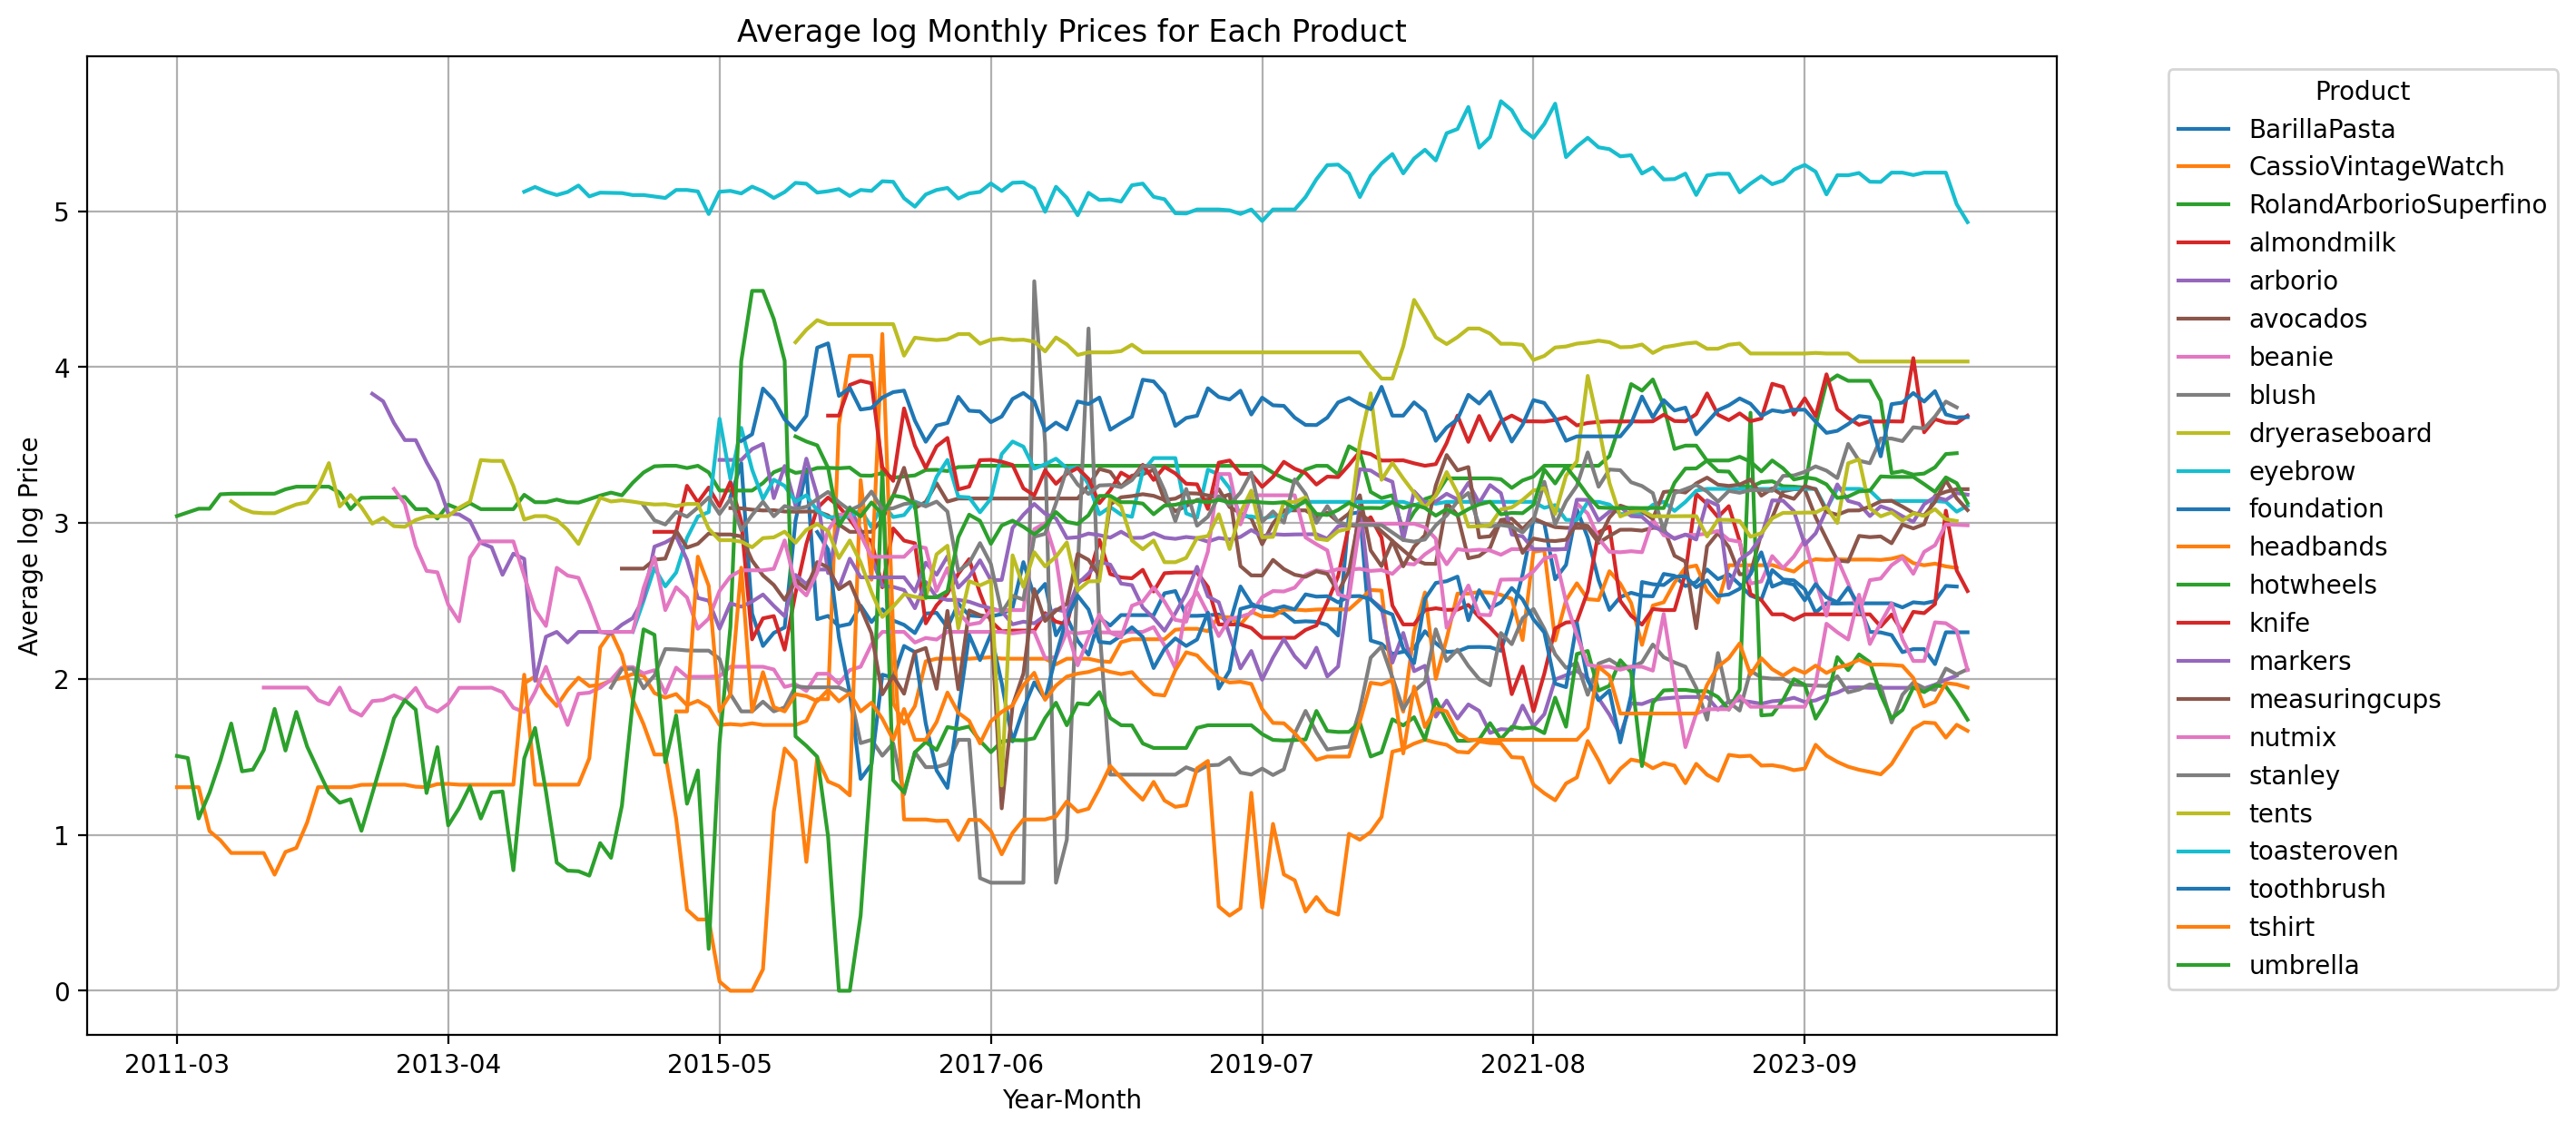

In [31]:
# Group by yearmonth and product, then calculate the average price
df_avg_monthly_prices = df3.groupby(['yearmonth', 'product'])['log_price'].mean().unstack()

# Plot the average monthly prices for each product
plt.figure(figsize=(14, 7))
df_avg_monthly_prices.plot(ax=plt.gca())

plt.xlabel('Year-Month')
plt.ylabel('Average log Price')
plt.title('Average log Monthly Prices for Each Product')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [32]:
# Calculate the average monthly price for each product
df3['avg_monthly_price'] = df3.groupby(['yearmonth', 'product'])['price'].transform('mean')
df3.head()

,date,price,asin,market,product_name,product,treatment,post,log_price,treatment_post,yearmonth,product_code,avg_monthly_price
0,2013-11-04,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679,0,2013-11,19,169.509259
1,2013-11-05,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679,0,2013-11,19,169.509259
2,2013-11-06,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679,0,2013-11,19,169.509259
3,2013-11-07,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679,0,2013-11,19,169.509259
4,2013-11-08,179.95,B00357YS3A,us,toasteroven,toasteroven,0,0,5.192679,0,2013-11,19,169.509259


In [33]:
# Filter the dataframe for products with treatment == 1
df_treatment_1 = df3[df3['treatment'] == 1]

# Group by yearmonth and product, then calculate the average price
df_avg_monthly_prices_treatment_1 = df_treatment_1.groupby(['yearmonth', 'product'])['log_price'].mean().unstack()
# Calculate the average monthly price for each product whose treatment == 1
df3['avgmonthlytreat'] = df3[df3['treatment'] == 1].groupby(['yearmonth', 'product'])['log_price'].transform('mean')
# Display the result
df_avg_monthly_prices_treatment_1.head()

product,BarillaPasta,CassioVintageWatch,RolandArborioSuperfino,almondmilk,arborio,avocados,beanie,blush,dryeraseboard,eyebrow,...,knife,markers,measuringcups,nutmix,stanley,tents,toasteroven,toothbrush,tshirt,umbrella
yearmonth,,,,,,,,,,,,,,,,,,,,,
2011-03,NaN,NaN,3.044522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04,NaN,NaN,3.068010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05,NaN,NaN,3.091497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06,NaN,NaN,3.091497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,NaN,NaN,3.184092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


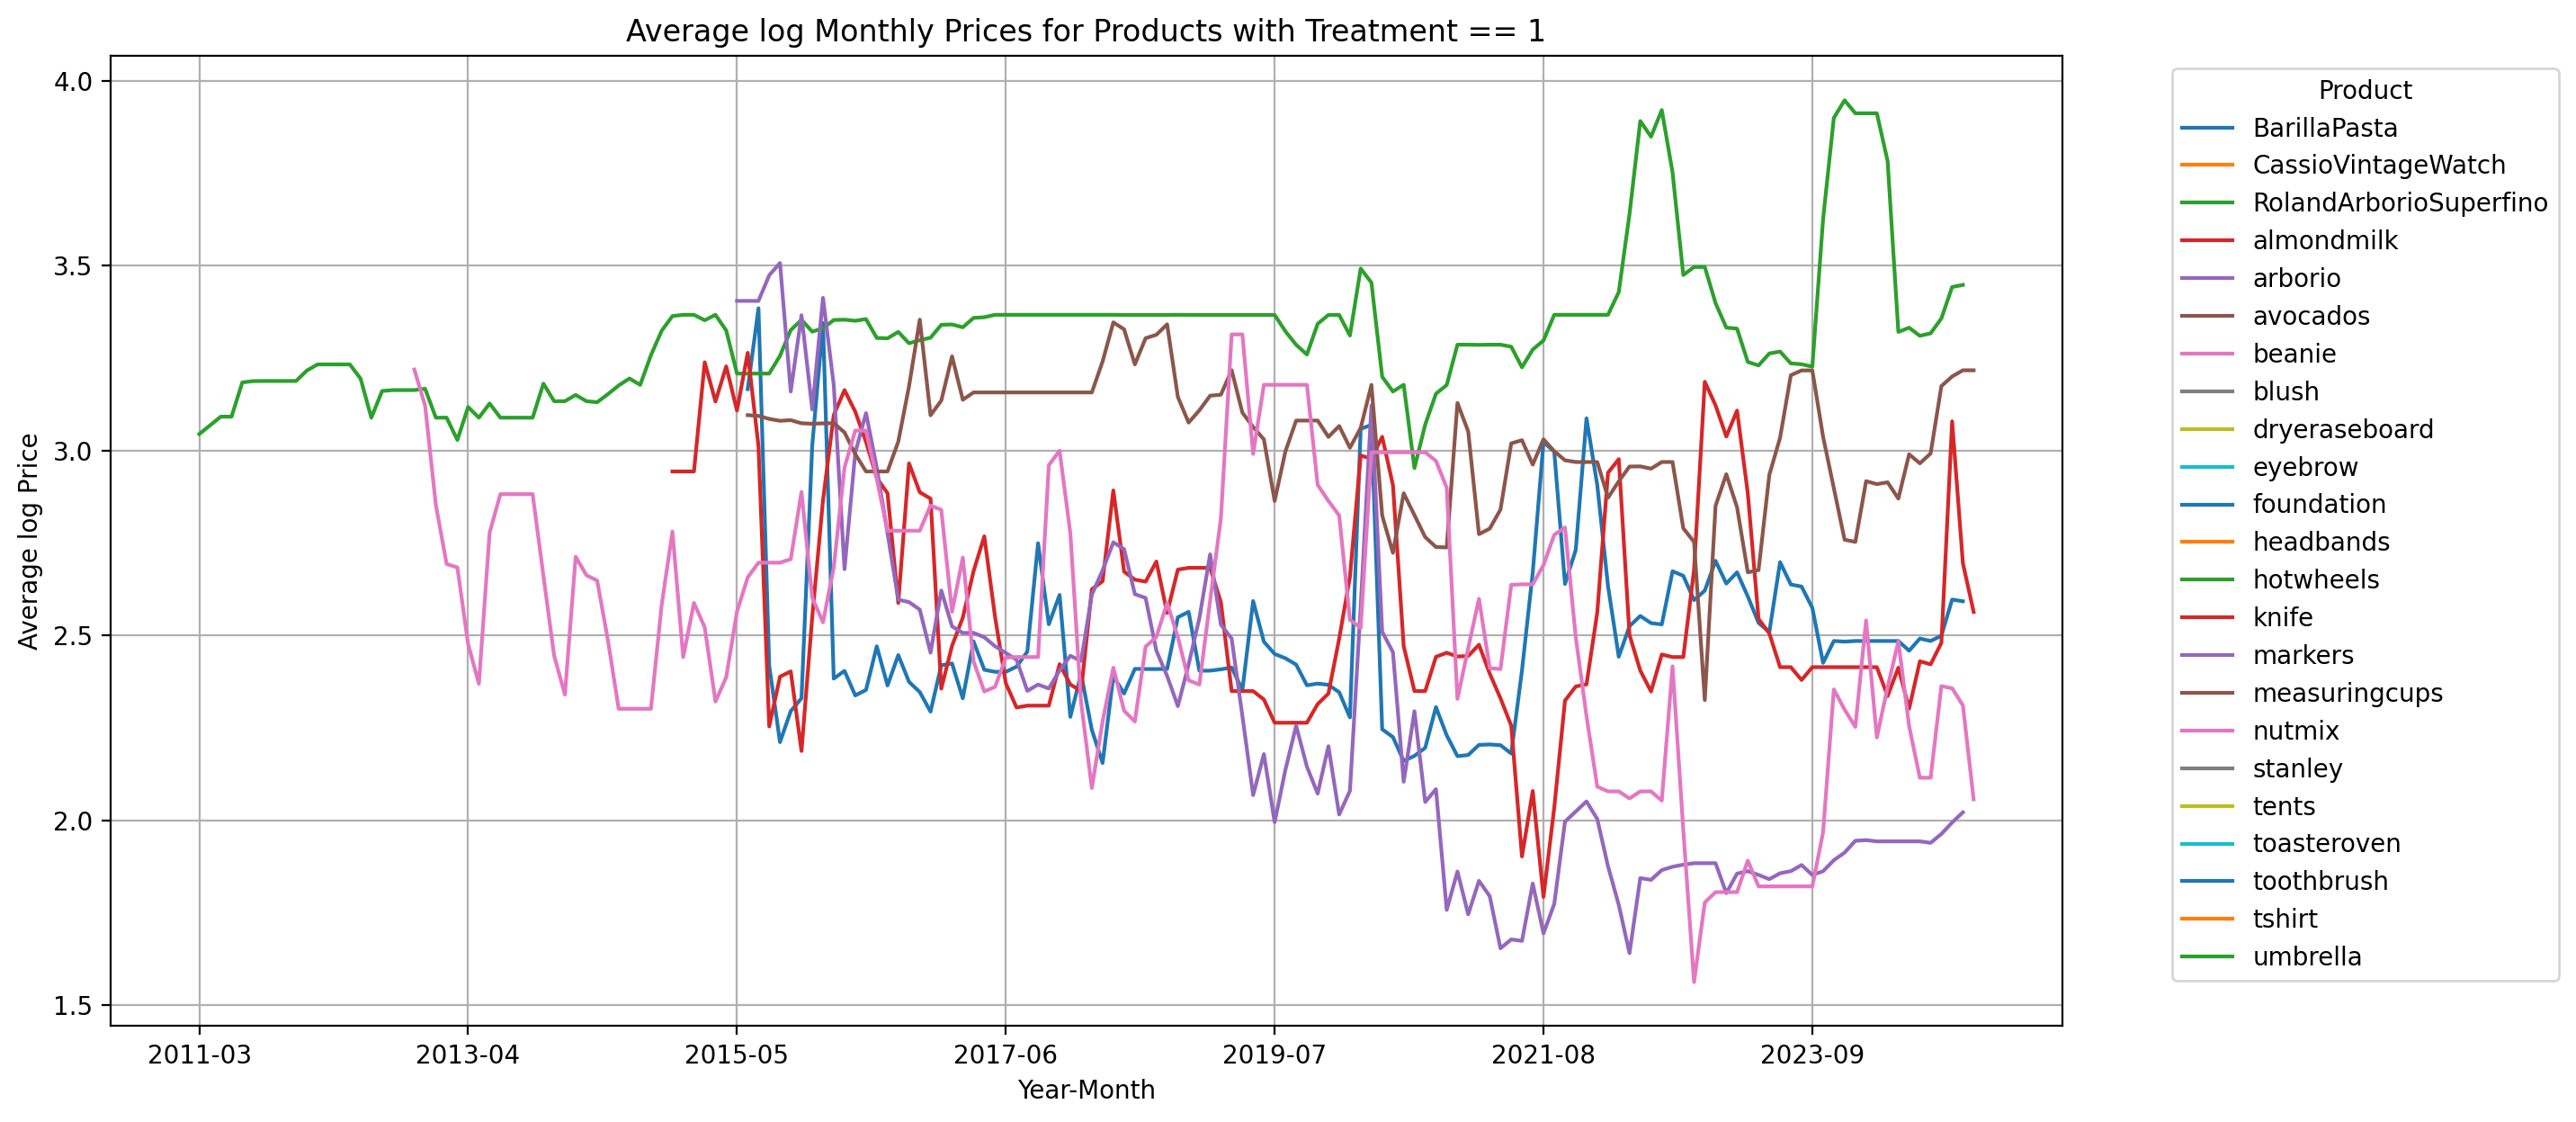

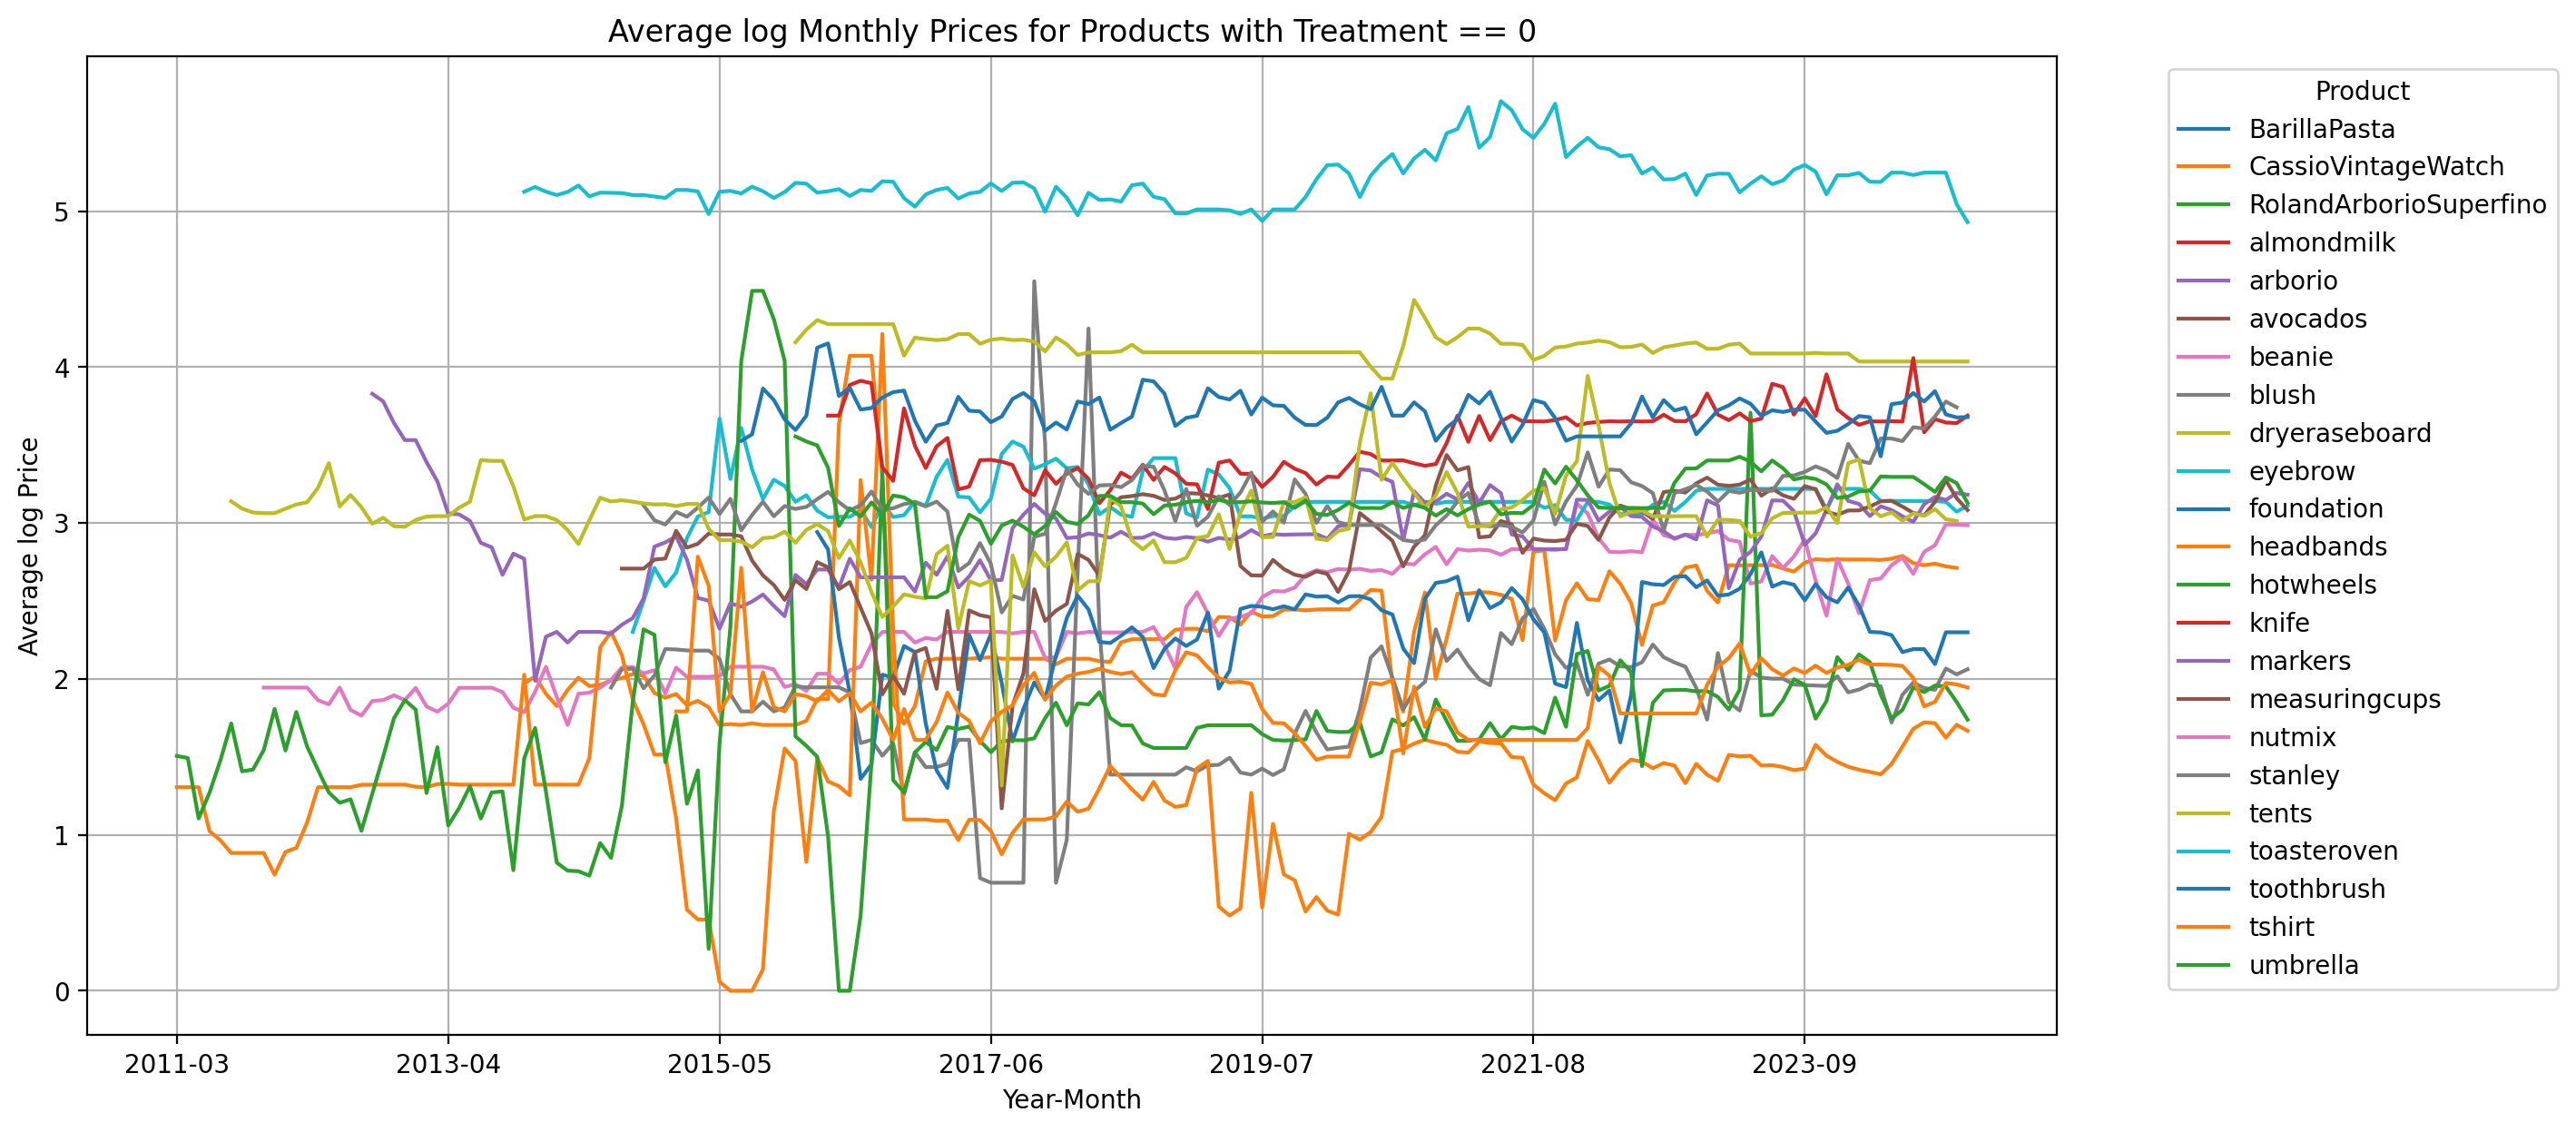

In [34]:
# Filter the dataframe for products with treatment == 1
df_treatment_1 = df3[df3['treatment'] == 1]

# Group by yearmonth and product, then calculate the average log price
df_avg_monthly_prices_treatment_1 = df_treatment_1.groupby(['yearmonth', 'product'])['log_price'].mean().unstack()

# Plot the average monthly log prices for each product with treatment == 1
plt.figure(figsize=(14, 7))
df_avg_monthly_prices_treatment_1.plot(ax=plt.gca())

plt.xlabel('Year-Month')
plt.ylabel('Average log Price')
plt.title('Average log Monthly Prices for Products with Treatment == 1')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Filter the dataframe for products with treatment == 0
df_treatment_0 = df3[df3['treatment'] == 0]

# Group by yearmonth and product, then calculate the average log price
df_avg_monthly_prices_treatment_0 = df_treatment_0.groupby(['yearmonth', 'product'])['log_price'].mean().unstack()

# Plot the average monthly log prices for each product with treatment == 0
plt.figure(figsize=(14, 7))
df_avg_monthly_prices_treatment_0.plot(ax=plt.gca())

plt.xlabel('Year-Month')
plt.ylabel('Average log Price')
plt.title('Average log Monthly Prices for Products with Treatment == 0')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

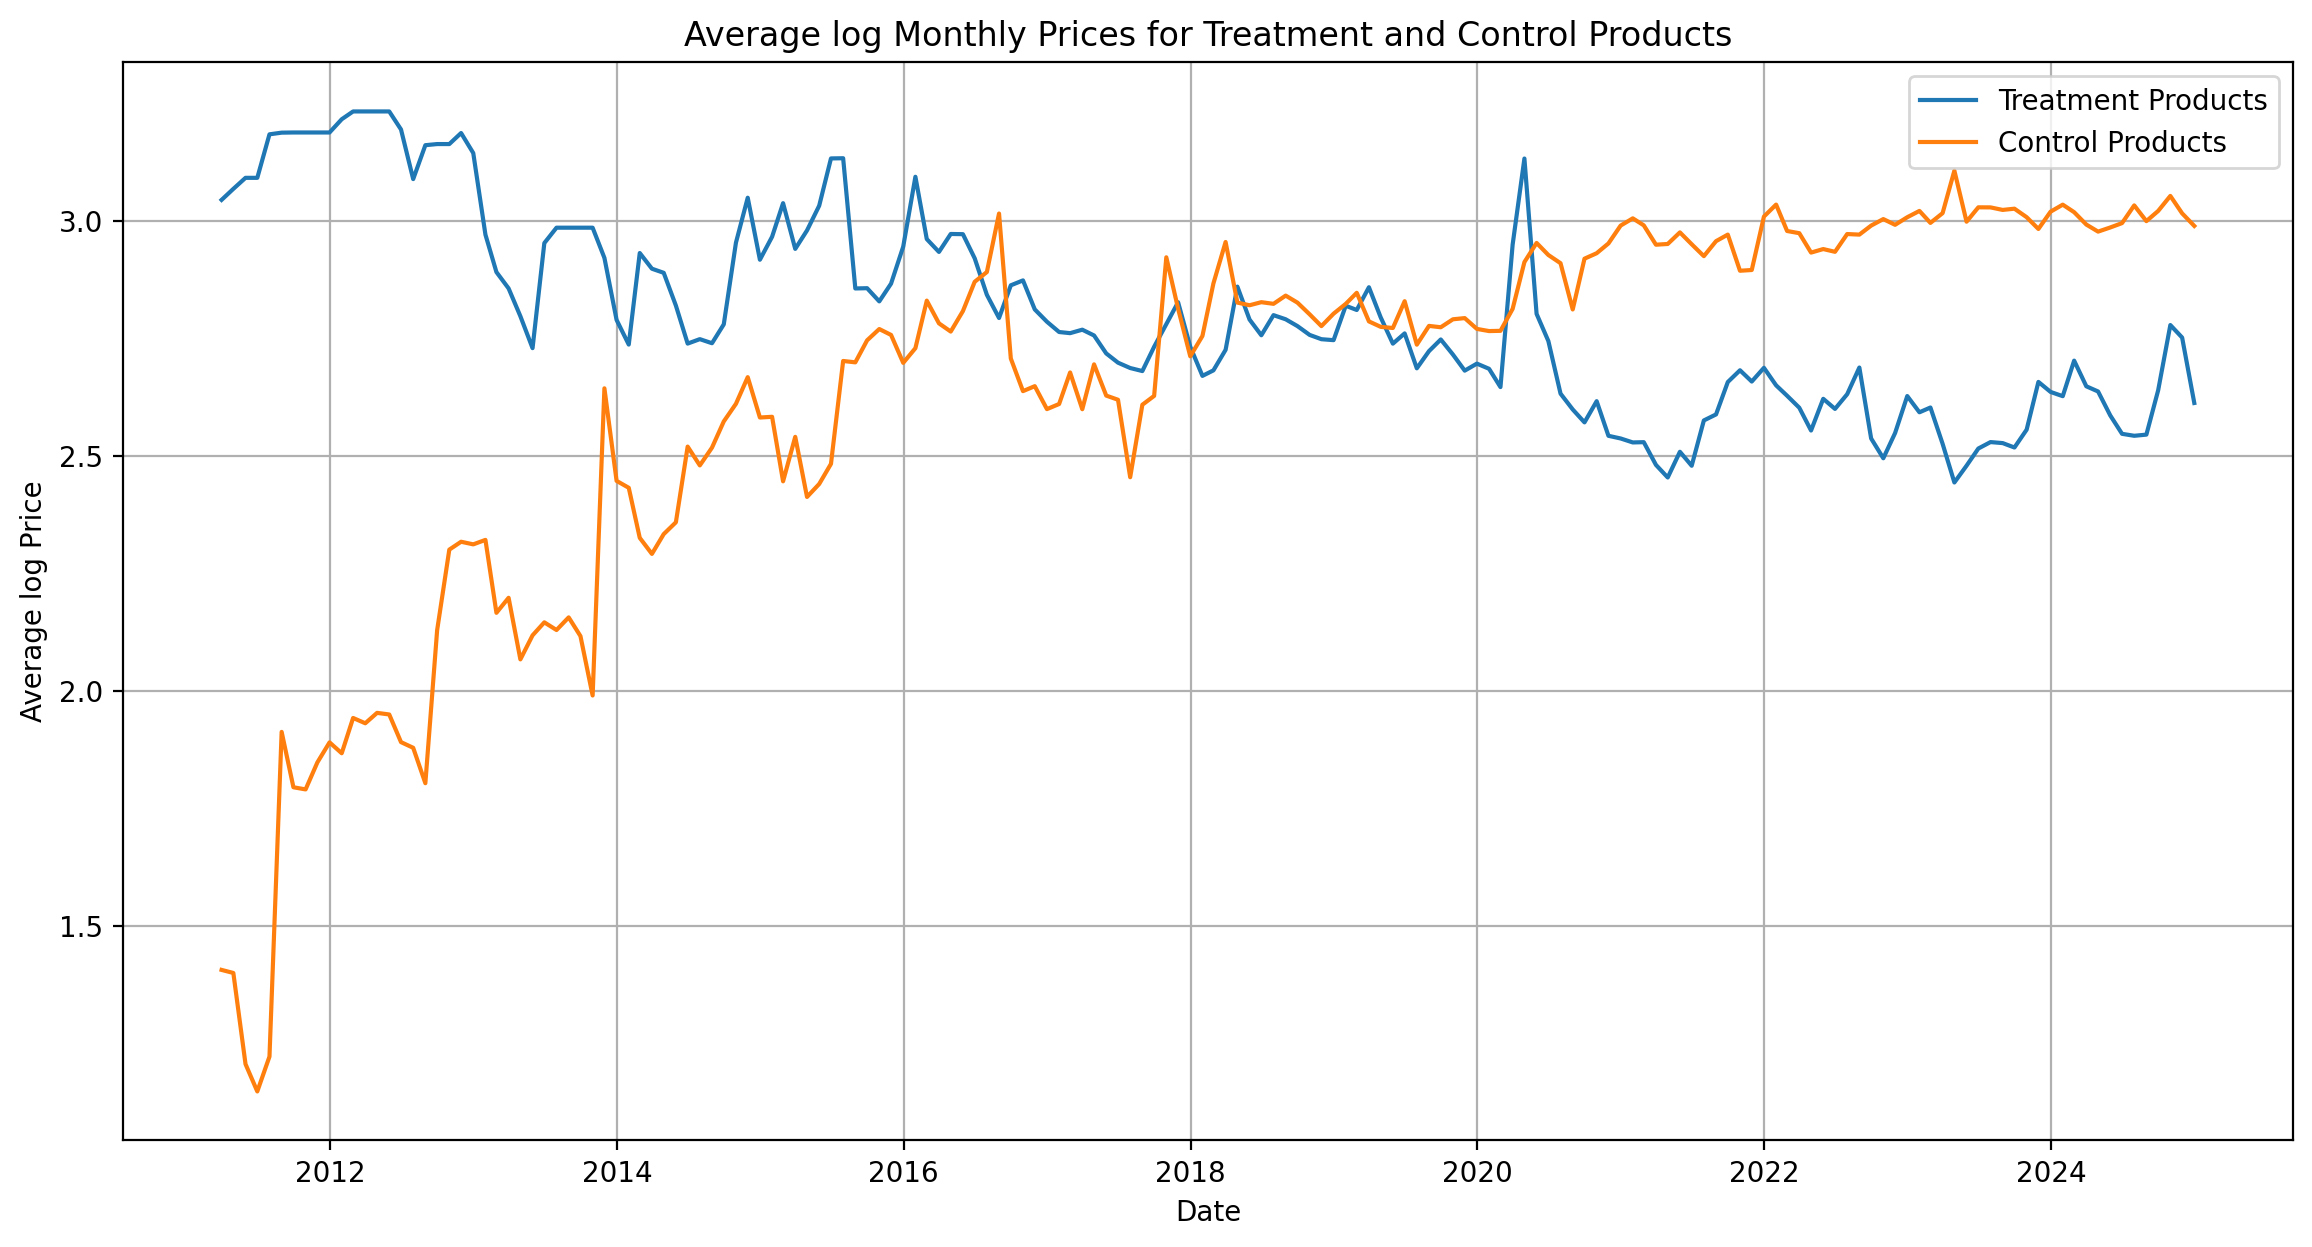

In [35]:
# Convert the 'date' column to datetime
df3["date"] = pd.to_datetime(df3["date"])

# Filter the dataframe for products with treatment == 1
df_treatment_1 = df3[df3['treatment'] == 1]

# Filter the dataframe for products with treatment == 0
df_treatment_0 = df3[df3['treatment'] == 0]

# Group by date and calculate the average log price for treatment products
df_avg_monthly_prices_treatment = df_treatment_1.groupby(pd.Grouper(key='date', freq='M'))['log_price'].mean()

# Group by date and calculate the average log price for control products
df_avg_monthly_prices_control = df_treatment_0.groupby(pd.Grouper(key='date', freq='M'))['log_price'].mean()

# Create the line plot
plt.figure(figsize=(14, 7))
plt.plot(df_avg_monthly_prices_treatment, label='Treatment Products')
plt.plot(df_avg_monthly_prices_control, label='Control Products')

plt.xlabel('Date')
plt.ylabel('Average log Price')
plt.title('Average log Monthly Prices for Treatment and Control Products')
plt.legend()
plt.grid(True)
plt.show()

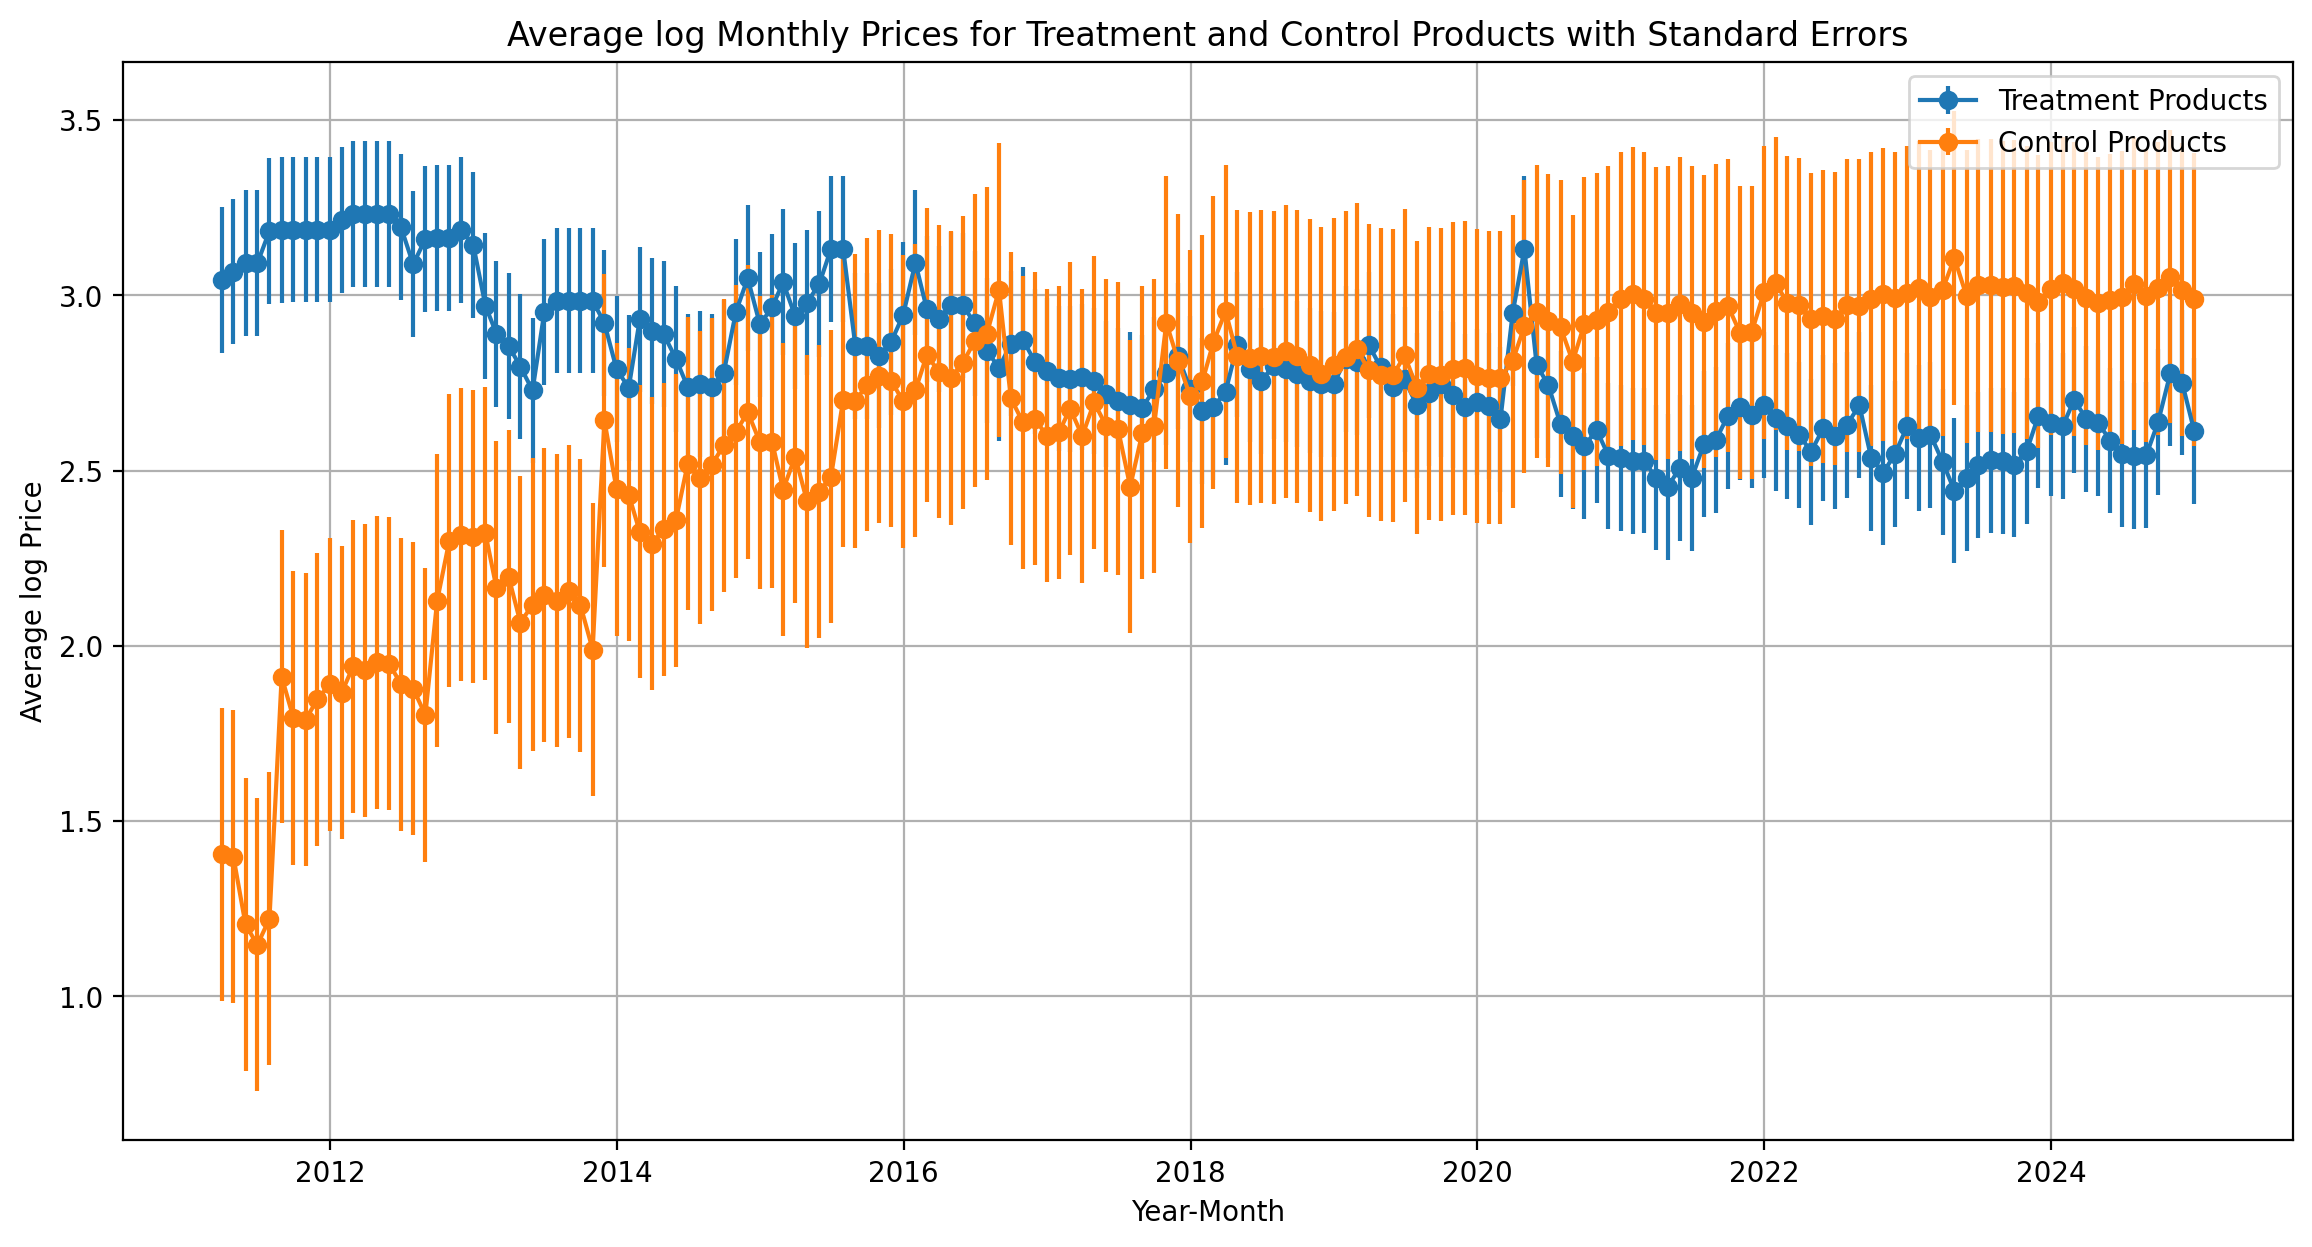

In [36]:
# Extract the standard errors for treatment and control groups
treatment_errors = df_avg_monthly_prices_treatment.std()
control_errors = df_avg_monthly_prices_control.std()

# Plot the average monthly log prices for each product with treatment == 1
plt.figure(figsize=(14, 7))
plt.errorbar(df_avg_monthly_prices_treatment.index, df_avg_monthly_prices_treatment, yerr=treatment_errors, label='Treatment Products', fmt='-o')

# Plot the average monthly log prices for each product with treatment == 0
plt.errorbar(df_avg_monthly_prices_control.index, df_avg_monthly_prices_control, yerr=control_errors, label='Control Products', fmt='-o')

plt.xlabel('Year-Month')
plt.ylabel('Average log Price')
plt.title('Average log Monthly Prices for Treatment and Control Products with Standard Errors')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the event date and window
event_date = pd.Timestamp('2017-11-01')
window = 30*24

# Filter the data for the event window (e.g., 30 days before and after the event)
df_event_window = df3[(df3['date'] >= event_date - pd.Timedelta(days=window)) & (df3['date'] <= event_date + pd.Timedelta(days=window))]

# Separate data for specific products
df_roland_arborio_superfino_event = df_event_window[df_event_window['product_name'] == 'RolandArborioSuperfino']
df_stanley_event = df_event_window[df_event_window['product_name'] == 'stanley']

# Plot the event study graph
plt.figure(figsize=(14, 7))

plt.plot(df_roland_arborio_superfino_event['date'], df_roland_arborio_superfino_event['price'], label='Roland Arborio Superfino', marker='o')
plt.plot(df_stanley_event['date'], df_stanley_event['price'], label='Stanley', marker='o')

plt.axvline(event_date, color='red', linestyle='--', label='Event Date (Nov 1, 2017)')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Event Study: Prices around Event Date (Nov 1, 2017)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Convert dates to numeric for regression
df_roland_arborio_superfino_event['date_numeric'] = (df_roland_arborio_superfino_event['date'] - event_date).dt.days
df_stanley_event['date_numeric'] = (df_stanley_event['date'] - event_date).dt.days

# Fit linear regression for Roland Arborio Superfino
model_roland = LinearRegression()
model_roland.fit(
    df_roland_arborio_superfino_event[['date_numeric']], 
    df_roland_arborio_superfino_event['price']
)

# Fit linear regression for Stanley
model_stanley = LinearRegression()
model_stanley.fit(
    df_stanley_event[['date_numeric']], 
    df_stanley_event['price']
)

# Generate fitted lines
roland_fitted = model_roland.predict(df_roland_arborio_superfino_event[['date_numeric']])
stanley_fitted = model_stanley.predict(df_stanley_event[['date_numeric']])

# Plot the event study graph
plt.figure(figsize=(14, 7))

# Plot the fitted lines
plt.plot(
    df_roland_arborio_superfino_event['date'], 
    roland_fitted, 
    label='Fitted Line (Roland Arborio Superfino)', linestyle='--'
)
plt.plot(
    df_stanley_event['date'], 
    stanley_fitted, 
    label='Fitted Line (Stanley)', linestyle='--'
)

# Add vertical line for the event date
plt.axvline(event_date, color='red', linestyle='--', label='Event Date (Nov 1, 2017)')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Event Study: Prices around Event Date (Nov 1, 2017)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the event date and window
event_date = pd.Timestamp('2017-11-01')
window = 30*24

# Filter the data for the event window (e.g., 30 days before and after the event)
df_event_window = df3[(df3['date'] >= event_date - pd.Timedelta(days=window)) & (df3['date'] <= event_date + pd.Timedelta(days=window))]

# Separate data for specific products
df_roland_arborio_superfino_event = df_event_window[df_event_window['product_name'] == 'RolandArborioSuperfino']
df_stanley_event = df_event_window[df_event_window['product_name'] == 'tents']

# Plot the event study graph
plt.figure(figsize=(14, 7))

plt.plot(df_roland_arborio_superfino_event['date'], df_roland_arborio_superfino_event['price'], label='Roland Arborio Superfino', marker='o')
plt.plot(df_stanley_event['date'], df_stanley_event['price'], label='Tent for Two', marker='o')

plt.axvline(event_date, color='red', linestyle='--', label='Event Date (Nov 1, 2017)')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Event Study: Prices around Event Date (Nov 1, 2017)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot the event study graph with fitted lines
plt.figure(figsize=(14, 7))


# Plot the fitted lines
plt.plot(df_roland_arborio_superfino_event['date'], roland_fitted, label='Fitted Line (Roland Arborio Superfino)', linestyle='--')
plt.plot(df_stanley_event['date'], stanley_fitted, label='Fitted Line (Stanley)', linestyle='--')

# Add vertical line for the event date
plt.axvline(event_date, color='red', linestyle='--', label='Event Date (Nov 1, 2017)')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Event Study: Prices around Event Date (Nov 1, 2017)')
plt.legend()
plt.grid(True)
plt.show()